In [1]:
import tensorflow as tf

import os
import time
import cv2
import numpy as np
import pandas as pd
import shutil
from glob import glob

from matplotlib import pyplot as plt
from IPython import display

In [2]:
numm = 256
RGBD_path = 'pics1\\'
point_path = 'point_folder\\'
error_path = 'GT_density\\'

In [3]:
pic = np.zeros([1,1])
def cross_validation(validnum):
    shutil.rmtree('point_folder\\train')
    shutil.rmtree('point_folder\\test')
    os.mkdir('point_folder\\train')
    os.mkdir('point_folder\\test')
    for i in range(5):
        files = glob('point_folder\\group' + str(i) + '\\*.png')
        if i == validnum:
            for file in files:
                name = list(file.split('\\'))[-1]
                cv2.imwrite('point_folder\\test\\' + name, pic)
        else:
            for file in files:
                name = list(file.split('\\'))[-1][:-4]
                cv2.imwrite('point_folder\\train\\' + name + '.png', pic)
                cv2.imwrite('point_folder\\train\\' + name + '_0.png', pic)
                cv2.imwrite('point_folder\\train\\' + name + '_1.png', pic)
                cv2.imwrite('point_folder\\train\\' + name + '_2.png', pic)

In [4]:
validnum = 0
cross_validation(validnum)

In [5]:
BUFFER_SIZE = 500
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256
# STEPS_PER_EPOCH = 512 // BATCH_SIZE

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
@tf.function
def load_image(point_file):
    name = tf.strings.split(point_file,'\\')[-1]

    RGBD = tf.io.read_file(RGBD_path + name)
    error = tf.io.read_file(error_path + name)
    RGBD = tf.image.decode_png(RGBD)
    error = tf.image.decode_png(error)[:, :, 0][0]
    
    RGBD = tf.cast(RGBD, tf.float32) / 255.0
    error = tf.cast(error, tf.float32) / 255.
#     error = tf.reshape(error, [numm*2]) # 这里要改
#     RGBD = tf.image.resize(RGBD, [256, 256],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return RGBD, error

In [8]:
output_channel = 1# 这里要改

In [9]:
# os.path.join(folder, 'point_folder', 'group' + str(i), '*.png')
train_dataset = tf.data.Dataset.list_files(point_path + 'train\\*.png')
train_dataset = train_dataset.map(load_image,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)#.repeat()

In [10]:
test_dataset = tf.data.Dataset.list_files(point_path+'test\\*.png')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [11]:
# Pretrain have a try
base_model = tf.keras.applications.EfficientNetB4(input_shape=[256, 256, 3], include_top=False, weights='imagenet')#here
# base_model = tf.keras.applications.vgg16.VGG16(input_shape=[256, 256, 1], include_top=False, weights=None)#这里要改

In [12]:
ptm = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)
# ptm.summary()

In [13]:
# # Fully Connection
# def IEF():
#     inputs = tf.keras.layers.Input(shape=[256,256,1]) #这里改数here
#     x = tf.keras.layers.Conv2D(64, 5, strides=4, padding='same')(inputs)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(128, 5, strides=4, padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(256, 5, strides=4, padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(512, 5, strides=4, padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(1, 1, strides=1)(x)

#     return tf.keras.Model(inputs=inputs, outputs=x)

In [14]:
# most simple
# def IEF():
#     inputs = tf.keras.layers.Input(shape=[256,256,1]) #这里改数here
#     x = tf.keras.layers.Flatten()(inputs)
#     x = tf.keras.layers.Dense(output_channel)(x)

#     return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
# 需要backbone的fully connected head
def IEF():
    inputs = tf.keras.layers.Input(shape=[256,256,3]) #这里改数here
    x = ptm(inputs)
    x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(2048, activation='relu')(x)#
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)#
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(output_channel)(x)#, activation='relu'

    return tf.keras.Model(inputs=inputs, outputs=x)

In [16]:
# 需要backbone的Fully Convolution
# def IEF():
#     inputs = tf.keras.layers.Input(shape=[256,256,4])
#     x = ptm(inputs)
#     x = tf.keras.layers.Conv2D(128, (5,5), strides=2, padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(256, (5,5), strides=2, padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(512, (5,5), strides=2, padding='same')(x)
# #     x = tf.keras.layers.BatchNormalization()(x)
# #     x = tf.keras.layers.LeakyReLU()(x)
# #     x = tf.keras.layers.Conv2D(1024, (5,5), strides=4, padding='same')(x)# there

#     return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
model = IEF()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 8, 8, 1792)        17673823  
_________________________________________________________________
flatten (Flatten)            (None, 114688)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              234883072 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 253,606,496
Trainable params: 253,481,289
Non-trainable params: 125,207
_______________________________________

In [18]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.MeanSquaredError())

In [19]:
checkpoint_filepath = 'weights_checkpoints/2_0'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [20]:
EPOCHS = 200
model_history = model.fit(train_dataset, epochs=EPOCHS,
#                           steps_per_epoch=STEPS_PER_EPOCH,
#                           validation_steps=128//BATCH_SIZE,
                          validation_data=test_dataset,
                          callbacks=[model_checkpoint_callback])

Epoch 1/200
52/52 [==============================] - 28s 245ms/step - loss: 431.5953 - val_loss: 0.1473
Epoch 2/200
52/52 [==============================] - 10s 182ms/step - loss: 0.3165 - val_loss: 0.1040
Epoch 3/200
52/52 [==============================] - 10s 180ms/step - loss: 0.2515 - val_loss: 0.2291
Epoch 4/200
52/52 [==============================] - 10s 178ms/step - loss: 0.1834 - val_loss: 0.0692
Epoch 5/200
52/52 [==============================] - 10s 178ms/step - loss: 0.0809 - val_loss: 0.1334
Epoch 6/200
52/52 [==============================] - 10s 179ms/step - loss: 0.0642 - val_loss: 0.0223
Epoch 7/200
52/52 [==============================] - 10s 179ms/step - loss: 0.0530 - val_loss: 0.0473
Epoch 8/200
52/52 [==============================] - 10s 178ms/step - loss: 0.0586 - val_loss: 0.0393
Epoch 9/200
52/52 [==============================] - 10s 177ms/step - loss: 0.0554 - val_loss: 0.0909
Epoch 10/200
52/52 [==============================] - 9s 176ms/step - loss: 0.05

Epoch 159/200
52/52 [==============================] - 11s 196ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 160/200
52/52 [==============================] - 10s 194ms/step - loss: 0.0018 - val_loss: 0.0062
Epoch 161/200
52/52 [==============================] - 10s 191ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 162/200
52/52 [==============================] - 10s 190ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 163/200
52/52 [==============================] - 10s 194ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 164/200
52/52 [==============================] - 10s 187ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 165/200
52/52 [==============================] - 10s 185ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 166/200
52/52 [==============================] - 11s 198ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 167/200
52/52 [==============================] - 11s 199ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 168/200
52/52 [==============================] - 11s 197ms

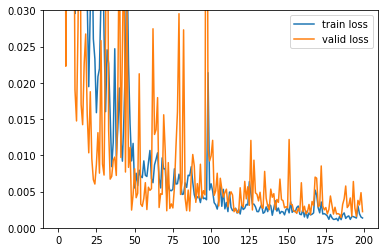

In [21]:
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='valid loss')
plt.legend()
plt.ylim(0, 0.03) 
plt.show()

In [22]:
model.load_weights(checkpoint_filepath)
# model.save(str(numm) + 'grapevine_' + str(validnum) + '.h5') 

In [23]:
def save_predictions():
    names = []
    preds = []
    files = glob('point_folder\\test\\' + '*.png')
    for file in files:
        name = list(file.split('\\'))[-1]
        names.append(name)
#         print(name)
        picture = tf.io.read_file(RGBD_path + name)
        picture = tf.image.decode_png(picture)
        picture = tf.cast(picture, tf.float32)
#         picture = tf.image.resize(picture, [256, 256],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        input_pic = np.reshape(picture, (1,256,256,3))/255.0#这里要改
        prediction = model.predict(input_pic)#255here
#         print(prediction*30+70)
        preds.append(prediction[0][0]*30+70)
    df = pd.DataFrame({'PicName':names, 'Prediction':preds})
    df.to_excel('Density_pred'+str(validnum) + '.xlsx')
#         cv2.imwrite('prediction_den_pics1\\' + name, prediction*255)

In [24]:
# start = time.time()
save_predictions()
# end = time.time()
# print(end - start)

In [25]:
# files = glob('prediction_pics1\\*.png')
# for file in files:
#     name = list(file.split('\\'))[-1]
#     pred = cv2.imread(file, 0)
#     print(name, pred)